In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy.signal import argrelextrema
from scipy.special import factorial
import matplotlib
from matplotlib import pyplot as plt

Assume $\hbar$=1

### 3 . Show that the vacuum |0i evolves into a coherent state under time-evolution (hint: show that the time-evolution operator has the form of a the displacement operator in the appropriate frame) and verify the result numerically by performing the time-evolution and comparing with the result (1). Note: you have to choose a finite Hilbert space for the photons. Take a sufficiently large cutoff 0 ≤ n ≤ nmax, with nmax = 100.

In [2]:
n_max=100
state_0=np.zeros(n_max)
state_0[0]=1
a=np.zeros((n_max,n_max))
a_d=np.zeros((n_max,n_max))

for i in range(n_max):
    a_d[i,i-1]=np.sqrt(i)

for i in range(n_max):
    a[i-1,i]=np.sqrt(i)

#state_0,a,a_d

Calculate the time evolution with the evolution operator $U=e^{-iHt}$.  

Let's calculate the hamiltonian.  

$$H=-d_{0}cos(\omega t)\hat{E}=-\frac{d_{0}}{2}(e^{i\omega}+e^{-i\omega})\hat{E}$$  

$$\hat{E}=E_{0}(e^{-i(\omega_{c}t+kr)}a+e^{i(\omega_{c}t+kr)}a\dagger$$

Where due to the long wave approximation we can set $kr=0$

Putting all together:

$$ H=-\frac{d_{0}E{0}}{2}[e^{it(\omega-\omega_{c})}a+e^{-it(\omega_{c}+\omega)}a+e^{it(\omega_{c}+\omega)}a\dagger+e^{-it(\omega_{c}-\omega)}a\dagger] $$  

Since $\omega_{c}=\omega)$, we can aply the RWA and get ride of the exponents which have both frequencies summing.  

Finally we arrive to our hamiltonian and time evolution operator.  

$$ H=-\frac{d_{0}E{0}}{2}(a+a\dagger) $$  

$$ U=exp(it\frac{d_{0}E{0}}{2}(a+a\dagger))$$  

In [3]:
def Hamiltonian(d0,E0):
    H=-d0*E0/2*(a_d+a)
    return(H)

In [4]:
def calc_state_t(d0,E0,tmax,state_0):
    U=linalg.expm(-1j*tmax*Hamiltonian(d0,E0))
    state=np.dot(U,state_0)
    return(state)

If we compare the time evolution operator an the displacement operator $D(\alpha)=exp(\alpha a\dagger + \alpha^*a)$ we can see that they are the same if:  

$$ \alpha=\frac{id_{0}E_{0}t}{2}$$  

We can use $D(\alpha)$ to calculate the time evoltution and observe that the final state is a coheren state.

$$D(\alpha) |0\rangle= |\alpha\rangle$$

Let's calculate directlt the coherent state.

In [5]:
def calc_coherent_state(d0,E0,tmax):
    alpha=E0*d0*tmax/2*1j
    constant=np.exp(-abs(alpha)**2/2)
    state_alpha=np.zeros(n_max,dtype=np.complex_)
    for n in range(n_max):
        state_alpha[n]=alpha**n/(np.sqrt(factorial(n)))
    state_alpha=constant*state_alpha
    return(state_alpha)

In [6]:
d0=1
E0=1
t_lim=20
time_=np.arange(0,t_lim,0.1)
dot_product=np.zeros(len(time_))

for i in range(len(time_)):
    
    dot_product[i]=np.vdot(calc_state_t(d0,E0,time_[i],state_0),calc_coherent_state(d0,E0,time_[i]))
    

/tmp/ipykernel_223/3994862327.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  dot_product[i]=np.vdot(calc_state_t(d0,E0,time_[i],state_0),calc_coherent_state(d0,E0,time_[i]))


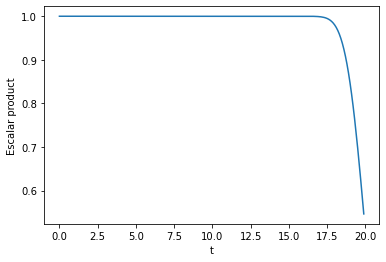

In [7]:
plt.plot(time_,dot_product)
plt.ylabel('Escalar product')
plt.xlabel('t')
plt.show()

For n=100, the two states are the same only for values of $t<\frac{20}{d_{0}E_{0}}$. If we want to increase the value of t we must increase the value of n.

### 4 . The photon number grows with time. Identify the time at which the generated coherent state has ¯n = 8 photons and verify it numerically.


Since $\bar{n}=|\alpha(t) |^2$ , we can compute analitically the value of t for $\bar{n}=8$

$$ t_{\bar{n}}=\frac{2\sqrt{\bar{n}}}{d_{0}E_{0}} $$

Afterwards we check numerically if:

$$ \langle \alpha(t_{8})|a\dagger a|\alpha(t_{8})\rangle$$

In [8]:
## Calculate analiticaly that: t=sqrt(2)*4/(d0*E0))
n_bar=8
t_n8=np.sqrt(n_bar)*2/(d0*E0)

## <state(t_n8)|a_d a|state(t_n8)>=8

state_t_n8=calc_state_t(d0,E0,t_n8,state_0)
operator_N=np.dot(a_d,a)
n_bar_calc=np.vdot(state_t_n8,np.dot(operator_N,state_t_n8))
print('n_bar=',n_bar_calc.round(3))

n_bar= (8+0j)


We can see that the average number of photons is 8.

### 5. We now turn off the oscillating dipole and consider a coherent state with ¯n = 8 photons coupled to an atom in its excited state, as done in class. Assume exact resonance between the cavity frequency and the two-level atom. Numerically compute the time evolution of the system under the Jaynes-Cummings Hamiltonian and extract the excited state population, Pe(t). Compare the curve with the exact result  showing the agreement.

In [9]:
g=1

In the interaction picture:  

$$ H_{JC}=\frac{g}{2}(|e\rangle \langle g| a + |g\rangle \langle e| a\dagger)$$

Our initial state is the previous coherent sate $|\alpha(t_{8})\rangle$.

In [10]:
def H_JC(g):
    H=np.zeros((2*n_max,2*n_max))
    sigma_p=[[0,1],[0,0]]
    sigma_n=[[0,0],[1,0]]
    H=g/2*(np.multiply.outer(sigma_p,a)+np.multiply.outer(sigma_n,a_d))
    H=H.swapaxes(1,2).reshape(2*n_max,2*n_max)

    return(H)

In [11]:
def calc_state_JC(g,t,state_0):
    U=linalg.expm(-1j*t*H_JC(g))
    state=np.dot(U,state_0)
    return(state)
    

The population of all the excited states is:

$$ Pe=\sum_{n}|{\langle e,n|\psi(t)\rangle|^2}$$

Being $|\psi(t)\rangle$ the state of the system at time t.

In [12]:
def calc_Pe(g,t,state_0):
    Pe=0
    for i in range(n_max):
        
        Pe_i=abs(calc_state_JC(g,t,state_0)[i+n_max])**2
        Pe=Pe+(Pe_i)
        

    return(Pe)

In [13]:
def analitical_Pe(g,t,n_bar):
    Pe=0
    C=np.exp(-n_bar)
    for i in range(n_max):
        value=n_bar**i/factorial(i)*np.cos(1/2*g*t*np.sqrt(i+1))**2
        Pe=Pe+value
    return((C*Pe))




In [14]:
state_e=[0,1]
state_g=[1,0]
state_0_2=np.outer(state_e,state_t_n8).reshape(n_max*2,)

In [15]:
t_max=50

In [16]:
time=np.arange(0,t_max,0.1)

Pe_list=np.zeros(len(time))

for i in range(len(time)):
    Pe_list[i]=calc_Pe(g,time[i],state_0_2)

    

In [40]:
time_a=np.arange(0,t_max,0.1)

Pe_list_a=np.zeros(len(time_a))

for i in range(len(time)):
    Pe_list_a[i]=analitical_Pe(g,time_a[i],n_bar)


Text(0.5, 0, 't')

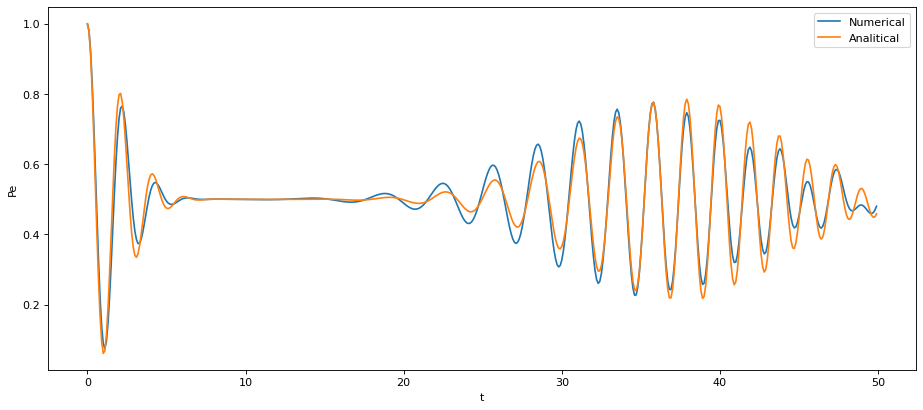

In [41]:
plt.figure(figsize=(14,6), dpi=80)
plt.plot(time,Pe_list,label='Numerical')
plt.plot(time_a,Pe_list_a,label='Analitical')
plt.legend()
plt.ylabel('Pe')
plt.xlabel('t')

### 6. Verify the presence of three relevant time-scales: τRabi, τcollapse and τrevival and quantitatively compare them with the results obtained analytically [hint: for the collapse part, fit the curve with an appropriate ansatz and compare the fitting parameters with the expected ones calculated in class (Rabi frequency and collapse time)].

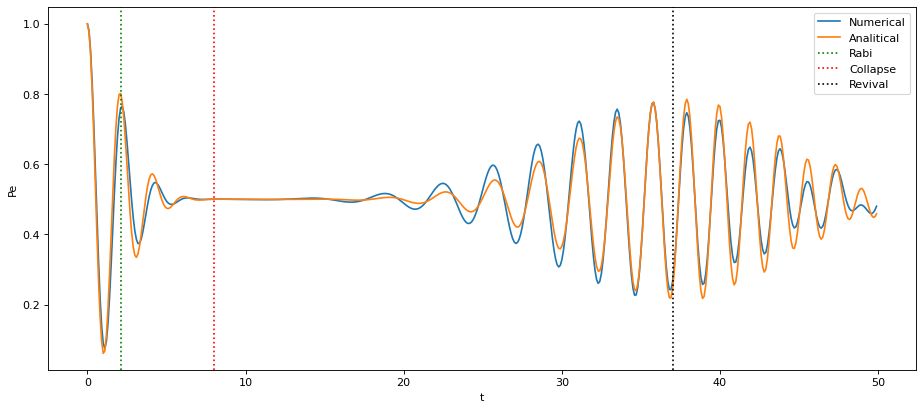

In [19]:
plt.figure(figsize=(14,6), dpi=80)
plt.plot(time,Pe_list,label='Numerical')
plt.plot(time_a,Pe_list_a,label='Analitical')
plt.ylabel('Pe')
plt.xlabel('t')
plt.axvline(2.1,color='g',linestyle='dotted',label='Rabi')
plt.axvline(8,color='r',linestyle='dotted',label='Collapse')
plt.axvline(37,color='black',linestyle='dotted',label='Revival')
plt.legend()
plt.show()

We can observe that there are 3 different relevant time-scales

As seen in class the function $P_e(t)$ for values smaller than $\tau_{Collapse}$ can be approximated as:  

$$ P_e=\frac{1}{2}+\frac{1}{2}cos(\sqrt{\bar{n}}gt)e^{-\frac{g^2t^2}{8}} $$  

Were the constant multipliying the exponent is $\tau_{decay}^2$ and the constant inside de cosine is $\frac{2\pi}{\tau_{Rabi}}$.  

As we saw in class, $\tau_{collapse}=\frac{4\pi}{g}$.

Then $\tau_{collapse} =\sqrt{2}\pi\tau_{decay}$.  

So finally we obtain the next expression which we can fit.  

$$ P_e=\frac{1}{2}+\frac{1}{2}cos(\sqrt{\bar{n}}gt)e^{-\frac{t^2}{\tau_{decay}^2}} $$  

$$ \tau_{collapse}= \sqrt{2}\pi\tau_{decay} = \frac{4\pi}{g} $$  
$$ \tau_{Rabi}=\frac{2\pi}{\sqrt{\bar{n}}g}$$

For $g=1$ and $\bar{n}=8$, if we compute this values analitically we obtain:  
$$ \tau_{collapse}= 4\pi $$  
$$ \tau_{Rabi}= \frac{\pi}{\sqrt{2}}$$



In [20]:
t_c_ana=4*np.pi/g
t_R_ana=2*np.pi/np.sqrt(n_bar)/g
print('tau_{collapse}=',t_c_ana)
print('tau_{Rabi}=',t_R_ana)

tau_{collapse}= 12.566370614359172
tau_{Rabi}= 2.221441469079183


In [21]:
def Pe_collapse(g,t):
    return(1/2+1/2*np.cos(np.sqrt(n_bar)*g*t)*np.exp(-g**2*t**2/8))

In [22]:
time_c=np.arange(0,t_max,0.1)

Pe_list_c=np.zeros(len(time_a))

for i in range(len(time)):
    Pe_list_c[i]=Pe_collapse(g,time[i])


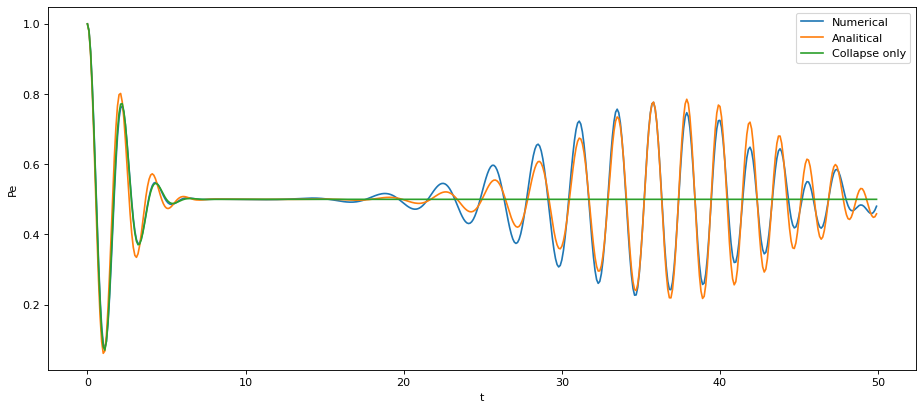

In [23]:
plt.figure(figsize=(14,6), dpi=80)
plt.plot(time,Pe_list,label='Numerical')
plt.plot(time_a,Pe_list_a,label='Analitical')
plt.plot(time_c,Pe_list_c,label='Collapse only')

plt.legend()
plt.ylabel('Pe')
plt.xlabel('t')
plt.show()

The approximation is correct, closer to numerical than to analitical.

Now let's make a fit with the data computed numerically and compare the results with the analitical results.

In [24]:
def func_fit(t,C,R):
    return(1/2+1/2*np.cos(2*np.pi/R*t)*np.exp(-2*np.pi**2*t**2/C**2))

In [25]:
mask=time<10 ##only take data from t<10, where the approximation is valid
fit=optimize.curve_fit(func_fit,time[mask],Pe_list[mask])
t_c_num=fit[0][0]
t_R_num=fit[0][1]
print('tau_{collapse}=',t_c_num)
print('tau_{Rabi}=',t_R_num)

tau_{collapse}= 12.419050109889147
tau_{Rabi}= 2.2380380447838344


In [26]:
print('The relative error for tau_{collapse} is:',abs(t_c_num-t_c_ana)/t_c_ana*100,'%')
print('The relative error for tau_{Rabi} is:',abs(t_R_num-t_R_ana)/t_R_ana*100,'%')

The relative error for tau_{collapse} is: 1.1723393252598104 %
The relative error for tau_{Rabi} is: 0.747108394961711 %


We define the revival time as the one when appears the greater local extrema in absolute value after the collaps.  

In class we have obtained the following value:  

$$\tau_{revival}=\frac{4\pi\sqrt{\bar{n}}}{g}=8 \sqrt{2}\pi$$

In [27]:
t_r_ana=4*np.pi*np.sqrt(n_bar)/g
print('tau_{revival}=',np.round(t_r_ana,1))

tau_{revival}= 35.5


In [28]:
maxima=np.max(argrelextrema(Pe_list[time>10],np.greater))
minima=np.min(argrelextrema(Pe_list[time>10],np.less))
t_r_num=time[np.max([abs(minima),maxima])]#take the values of t for the greater local extrema in absolute value
print('tau_{revival}=',np.round(t_r_num,1))

tau_{revival}= 38.8


In [29]:
print('The relative error for tau_{revival} is:',abs(t_r_num-t_r_ana)/t_r_ana*100,'%')

The relative error for tau_{revival} is: 9.163353334049127 %


### 7. Given the low photon occupation of the coherent state (¯n = 8), you should have found a small discrepancy with the expected values which depends on ¯n. Repeat the calculation for the collapse time more accurately to find the improved result τcollapse and verify it agrees with the numerical output for different values of ¯n. If needed, decrease the photon occupation enough to see a sizeable difference.


Let's see if the improved $\tau_{collapse}$ decreases the value of its relative errror, specially for low values of $\bar{n}$.  
$$\tau_{collapse,impr}=\sqrt{2}\pi 2\sqrt{\frac{2(\bar{n}+1)}{\bar{n}g^2}} $$

In [30]:
t_c_imp=2*np.sqrt(2)*np.pi*np.sqrt(2*(n_bar+1)/(n_bar*g**2))
print('tau_{collapse}=',np.round(t_c_imp,1))
rel_error=abs(t_c_num-t_c_imp)/t_c_imp*100
print('The relative error for tau_{collapse} is:',rel_error,'%')

tau_{collapse}= 13.3
The relative error for tau_{collapse} is: 6.824387957450828 %


(Calculations are made in a copy of this notebook, just changing the parameter n_bar)

In [31]:
n_bar_list=[2,4,8,16,32,64]
errors_imp=[180.17241783806764 ,12.482681939647247 ,6.826091307390136,3.578185299888022 ,1.8576706483887495,0.9201667579268062 ]
errors=[198.19075757423687 ,2.152663804290609 ,1.1741460006990503, 0.6106683444261632, 0.33599340338490663, 0.14910584299592058 ]

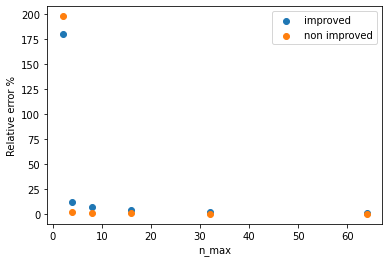

In [32]:
plt.scatter(n_bar_list,errors_imp,label='improved')
plt.scatter(n_bar_list,errors,label='non improved')
plt.legend()
plt.xlabel('n_max')
plt.ylabel('Relative error %')
plt.show()

The improved version yields greater errors except for n=2.

### 8. Let us now consider a different physical system displaying similar features: a small number of bosonic atoms on a single site of an optical lattice. Atoms are prepared in a coherent state and let evolve under the Hamiltonian HˆBH = U /2 nˆ(ˆn−1). Show that this generates a collapse and revival of the superfluid parameter ψ(t) = hα(t)|aˆ|α(t)i: derive the corresponding equation for ψ(t), the time-scales (Rabi, collapse and revival) and their relation to U and n¯. Finally check your results numerically.


$$H_{BH}=\frac{U}{2}\hat{n}(\hat{n}-1)$$

We want to compute:
$$ \psi(t)=\langle\alpha (t)|a| \alpha (t)\rangle=\langle\alpha |e^{iHt}ae^{-iHt}| \alpha\rangle$$

where $| \alpha\rangle$ is the initial coherent state.

We define $\alpha$ as the $\sqrt{number of atoms}$.

In [33]:
def H_BH(U):
    N=np.dot(a_d,a)
    return(U/2)*np.dot(N,(N-np.diag([1]*n_max)))


In [34]:
def ev_op_b(U,t,sign):
    ev_op=linalg.expm((-1)**sign*1j*t*H_BH(U))
    
    return(ev_op)

In [35]:
def calc_coherent_state_b(num_atoms):
    alpha=np.sqrt(num_atoms)
    constant=np.exp(-num_atoms/2)
    state_alpha=np.zeros(n_max)
    for n in range(n_max):
        state_alpha[n]=alpha**n/(np.sqrt(factorial(n)))
    state_alpha=constant*state_alpha
    return(state_alpha)

In [36]:
def psi(U,t,num_atoms,state_0_b):
    ev_op_p=ev_op_b(U,t,2)
    ev_op_n=ev_op_b(U,t,1)
    
    op=np.dot(ev_op_p,np.dot(a,ev_op_n))
    psi=np.vdot(state_0_b,np.dot(op,state_0_b))
    return(psi)

In [37]:
U=1
num_atoms=10 #take few atoms

In [38]:
t_lim=10
time_b=np.arange(0,t_lim,0.04)
psi_list=np.zeros(len(time_b),dtype=np.complex_)
state_0_b=calc_coherent_state_b(num_atoms)
for i in range(len(time_b)):
    psi_list[i]=psi(U,time_b[i],num_atoms,state_0_b)


/home/guillermo/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


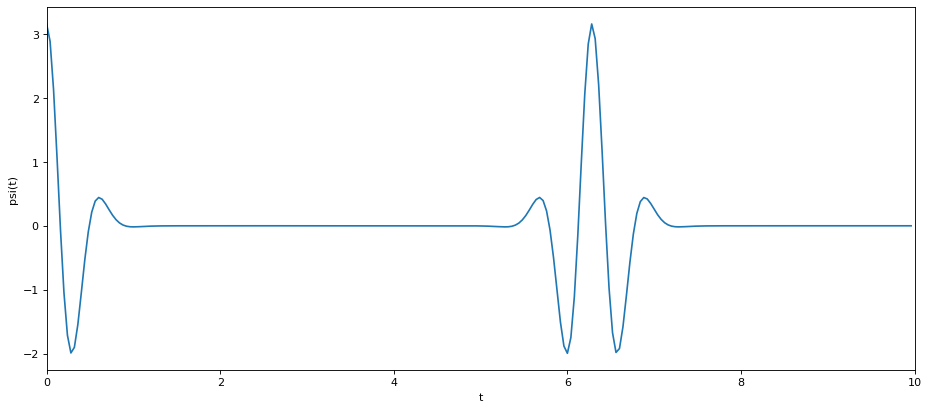

In [39]:
plt.figure(figsize=(14,6), dpi=80)
plt.plot(time_b,psi_list)
plt.xlim(0,10)
plt.ylabel('psi(t)')
plt.xlabel('t')
plt.show()

We can see properly the three time-scales.